In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
import xml.etree.ElementTree as ET


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *
import matplotlib.pyplot as plt


## License Plate Loader

In [2]:
''''class PlateDataset(Dataset):
    def __init__(self, opt):
        super(PlateDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = PlateCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        item = {'img': img, 'idx':index}
        item['label'] = imagefile.split('_')[0]
        return item 
    
'''

class PlateDataset(Dataset):
    def __init__(self, opt):
        super(PlateDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.annotations_path = os.path.join(opt['path'], 'annotations')  # Assuming annotations are in a folder named 'annotations'
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
        # transform_list = [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        transform_list = [transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = PlateCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        #print("imagefile: ", imagefile)
        img = Image.open(imagepath)
        #print("img.shape: ", img.shape)
        # Resize the image to a fixed height
        #img = img.resize((180, 32), Image.ANTIALIAS)
        
        print("Min pixel value:", np.min(img))
        print("Max pixel value:", np.max(img))

        # Visualize the image
        #plt.imshow(img)
        #plt.show()
        
        if self.transform is not None:
            img = self.transform(img)

        # Load corresponding annotation
        annotation_file = os.path.join(self.annotations_path, imagefile.replace('.png', '.xml'))
        labels = self.parse_annotation(annotation_file)

        item = {'img': img, 'idx': index, 'label': labels}
        return item

    def parse_annotation(self, annotation_file):
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            labels.append(name)

        # Concatenate the values inside <name> tags to form the label
        label = ''.join(labels)
        #print('label: ', label)

        return label


In [14]:
'''
class PlateCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item
    
'''


class PlateCollator(object):
    def __call__(self, batch):
        max_height = max(item['img'].shape[1] for item in batch)
        max_width = max(item['img'].shape[2] for item in batch)

        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], max_height, max_width], dtype=torch.float32)

        for idx, item in enumerate(batch):
            img = item['img']
            print("img.shape in collator: ", img.shape)
            height, width = img.shape[1], img.shape[2]
            imgs[idx, :, :height, :width] = img

        indexes = [item['idx'] for item in batch]

        item = {'img': imgs, 'idx': indexes, 'label': [item['label'] for item in batch]}
        return item

## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [4]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        print("Conv Size:", conv.size())

        if h != 1:
            # Perform resizing or cropping to make height 1
            # Example: 
            conv = F.adaptive_avg_pool2d(conv, (1, w))
            print("Resized/Cropped Conv Size:", conv.size())

        # assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1, 0)  # Tbh to bth
        return output

In [5]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [6]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output
    
    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [7]:
%env CUDA_VISIBLE_DEVICES=0
print(f'available devices: {torch.cuda.device_count()}')

env: CUDA_VISIBLE_DEVICES=0
available devices: 4


In [8]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        print("running fit method")
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'], strict=False)
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'], strict=False)

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [15]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'../data/LP-characters',
    'imgdir': 'train',
    'imgH':48,
    'nChannels':3,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':4,
    'batch_size':12,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':True,
    'schedule':False
    
}

data = PlateDataset(args)
args['collate_fn'] = PlateCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:133
Val Data Size:34


Epoch: [0]/[4] Training:   0%|          | 0/12 [00:00<?, ?it/s]

Let's use 4 GPUs!
checkpoint does not exist
running fit method
None
Scheduling is False
img.shape in collator:  torch.Size([3, 97, 207])
img.shape in collator:  torch.Size([3, 56, 144])
img.shape in collator:  torch.Size([3, 236, 489])
img.shape in collator:  torch.Size([3, 177, 747])
img.shape in collator:  torch.Size([3, 52, 210])
img.shape in collator:  torch.Size([3, 59, 194])
img.shape in collator:  torch.Size([3, 48, 142])
img.shape in collator:  torch.Size([3, 97, 276])
img.shape in collator:  torch.Size([3, 91, 295])
img.shape in collator:  torch.Size([3, 52, 168])
img.shape in collator:  torch.Size([3, 62, 210])
img.shape in collator:  torch.Size([3, 80, 268])
Conv Size: torch.Size([3, 512, 13, 187])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 13, 187])
Conv Size:Conv Size: torch.Size([3, 512, 1, 187])
 torch.Size([3, 512, 13, 187])
Resized/Cropped Conv Size: torch.Size([3, 512, 13, 187])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 187])
Resized/Cropped Conv

Epoch: [0]/[4] Training:  17%|█▋        | 2/12 [00:00<00:03,  2.69it/s, loss=25.6, train_ca=0, train_wa=0]   

img.shape in collator:  torch.Size([3, 75, 215])
img.shape in collator:  torch.Size([3, 61, 97])
img.shape in collator:  torch.Size([3, 208, 283])
img.shape in collator:  torch.Size([3, 63, 223])
img.shape in collator:  torch.Size([3, 75, 281])
img.shape in collator:  torch.Size([3, 68, 216])
img.shape in collator:  torch.Size([3, 64, 202])
img.shape in collator:  torch.Size([3, 60, 110])
img.shape in collator:  torch.Size([3, 66, 205])
img.shape in collator:  torch.Size([3, 83, 225])
img.shape in collator:  torch.Size([3, 74, 173])
img.shape in collator:  torch.Size([3, 69, 212])
Conv Size: torch.Size([3, 512, 12, 71])
Resized/Cropped Conv Size:Conv Size:Conv Size: torch.Size([3, 512, 12, 71])
Conv Size: torch.Size([3, 512, 1, 71])
 torch.Size([3, 512, 12, 71])
Resized/Cropped Conv Size: torch.Size([3, 512, 12, 71])
 torch.Size([3, 512, 1, 71])
Resized/Cropped Conv Size:Resized/Cropped Conv Size:  torch.Size([3, 512, 1, 71])
torch.Size([3, 512, 1, 71])
img.shape in collator:  torch.Si

Epoch: [0]/[4] Training:  33%|███▎      | 4/12 [00:01<00:03,  2.58it/s, loss=13.4, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 62, 168])
img.shape in collator:  torch.Size([3, 56, 165])
img.shape in collator:  torch.Size([3, 52, 145])
img.shape in collator:  torch.Size([3, 107, 310])
img.shape in collator:  torch.Size([3, 312, 477])
img.shape in collator:  torch.Size([3, 74, 161])
img.shape in collator:  torch.Size([3, 133, 237])
img.shape in collator:  torch.Size([3, 45, 128])
img.shape in collator:  torch.Size([3, 71, 183])
img.shape in collator:  torch.Size([3, 55, 124])
img.shape in collator:  torch.Size([3, 154, 416])
img.shape in collator:  torch.Size([3, 74, 205])
Conv Size: torch.Size([3, 512, 18, 120])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 1, 120])
 torch.Size([3, 512, 18, 120])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 1, 120])
Conv Size:  torch.Size([3, 512, 18, 120])
Resized/Cropped Conv Size:torch.Size([3, 512, 18, 120])
 torch.Size([3, 512, 1, 120])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 120])
img.shape in collato

Epoch: [0]/[4] Training:  42%|████▏     | 5/12 [00:01<00:02,  3.07it/s, loss=5.46, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 67, 291])
img.shape in collator:  torch.Size([3, 52, 168])
img.shape in collator:  torch.Size([3, 72, 152])
img.shape in collator:  torch.Size([3, 43, 74])
img.shape in collator:  torch.Size([3, 109, 199])
img.shape in collator:  torch.Size([3, 50, 118])
img.shape in collator:  torch.Size([3, 526, 2043])
img.shape in collator:  torch.Size([3, 60, 159])
img.shape in collator:  torch.Size([3, 56, 113])
img.shape in collator:  torch.Size([3, 59, 129])
img.shape in collator:  torch.Size([3, 163, 464])
img.shape in collator:  torch.Size([3, 48, 209])
Conv Size:Conv Size: torch.Size([3, 512, 31, 511])
Conv Size: torch.Size([3, 512, 31, 511])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 31, 511])
 torch.Size([3, 512, 1, 511])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
 torch.Size([3, 512, 31, 511])
Resized/Cropped Conv Size:
Resized/Cropped Conv Size:  torch.Size([3, 512, 1, 511])
torch.Size([3, 512, 1, 511])


Epoch: [0]/[4] Training:  58%|█████▊    | 7/12 [00:02<00:01,  2.85it/s, loss=6.09, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 39, 179])
img.shape in collator:  torch.Size([3, 37, 189])
img.shape in collator:  torch.Size([3, 129, 312])
img.shape in collator:  torch.Size([3, 66, 176])
img.shape in collator:  torch.Size([3, 46, 105])
img.shape in collator:  torch.Size([3, 75, 300])
img.shape in collator:  torch.Size([3, 47, 124])
img.shape in collator:  torch.Size([3, 58, 176])
img.shape in collator:  torch.Size([3, 56, 126])
img.shape in collator:  torch.Size([3, 97, 459])
img.shape in collator:  torch.Size([3, 110, 399])
img.shape in collator:  torch.Size([3, 59, 151])
Conv Size: torch.Size([3, 512, 7, 115])
Conv Size:Conv Size: torch.Size([3, 512, 7, 115])
 torch.Size([3, 512, 7, 115])Resized/Cropped Conv Size:
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
 torch.Size([3, 512, 1, 115])
Conv Size: torch.Size([3, 512, 7, 115])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
img.shape in collator:  to

Epoch: [0]/[4] Training:  75%|███████▌  | 9/12 [00:02<00:00,  3.91it/s, loss=6.7, train_ca=0, train_wa=0] 

img.shape in collator:  torch.Size([3, 46, 124])
img.shape in collator:  torch.Size([3, 52, 159])
img.shape in collator:  torch.Size([3, 63, 238])
img.shape in collator:  torch.Size([3, 110, 403])
img.shape in collator:  torch.Size([3, 73, 283])
img.shape in collator:  torch.Size([3, 59, 230])
img.shape in collator:  torch.Size([3, 83, 209])
img.shape in collator:  torch.Size([3, 47, 139])
img.shape in collator:  torch.Size([3, 73, 203])
img.shape in collator:  torch.Size([3, 154, 406])
img.shape in collator:  torch.Size([3, 114, 144])
img.shape in collator:  torch.Size([3, 133, 272])
Conv Size:Conv Size: torch.Size([3, 512, 8, 102])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 102])
Conv Size: torch.Size([3, 512, 8, 102])
 torch.Size([3, 512, 8, 102])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 102])
 torch.Size([3, 512, 8, 102])
 torch.Size([3, 512, 1, 102])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 102])
img.shape in collator:  

Epoch: [0]/[4] Training:  83%|████████▎ | 10/12 [00:03<00:00,  3.27it/s, loss=5.23, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 49, 162])
img.shape in collator:  torch.Size([3, 78, 196])
img.shape in collator:  torch.Size([3, 74, 157])
img.shape in collator:  torch.Size([3, 77, 157])
img.shape in collator:  torch.Size([3, 51, 111])
img.shape in collator:  torch.Size([3, 61, 198])
img.shape in collator:  torch.Size([3, 62, 201])
img.shape in collator:  torch.Size([3, 89, 313])
img.shape in collator:  torch.Size([3, 110, 153])
img.shape in collator:  torch.Size([3, 56, 143])
img.shape in collator:  torch.Size([3, 127, 479])
img.shape in collator:  torch.Size([3, 294, 1374])
Conv Size:Conv Size:  torch.Size([3, 512, 17, 344])
Resized/Cropped Conv Size:Conv Size:torch.Size([3, 512, 17, 344])
Resized/Cropped Conv Size: torch.Size([3, 512, 17, 344])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 344])
  torch.Size([3, 512, 1, 344])torch.Size([3, 512, 1, 344])

 torch.Size([3, 512, 17, 344])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 344])


Validating:  33%|███▎      | 1/3 [00:00<00:00,  9.61it/s, val_loss=3.93, val_ca=0, val_wa=0]

img.shape in collator:  torch.Size([3, 49, 180])
Conv Size: torch.Size([1, 512, 2, 46])
Resized/Cropped Conv Size: torch.Size([1, 512, 1, 46])
img.shape in collator:  torch.Size([3, 167, 247])
img.shape in collator:  torch.Size([3, 293, 684])
img.shape in collator:  torch.Size([3, 44, 110])
img.shape in collator:  torch.Size([3, 47, 144])
img.shape in collator:  torch.Size([3, 59, 177])
img.shape in collator:  torch.Size([3, 114, 550])
img.shape in collator:  torch.Size([3, 108, 351])
img.shape in collator:  torch.Size([3, 68, 164])
img.shape in collator:  torch.Size([3, 110, 203])
img.shape in collator:  torch.Size([3, 33, 97])
img.shape in collator:  torch.Size([3, 68, 209])
img.shape in collator:  torch.Size([3, 87, 243])
Conv Size: torch.Size([3, 512, 17, 172])
Conv Size: torch.Size([3, 512, 17, 172])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 172])
Conv Size:Conv Size: torch.Size([3, 512, 1, 172]) torch.Size([3, 512, 17, 172])
 torch.Size([3, 512, 

Validating:  67%|██████▋   | 2/3 [00:00<00:00,  7.24it/s, val_loss=3.84, val_ca=0, val_wa=0]

torch.Size([3, 39, 153])
img.shape in collator:  torch.Size([3, 77, 160])
img.shape in collator:  torch.Size([3, 239, 459])
img.shape in collator:  torch.Size([3, 108, 243])
img.shape in collator:  torch.Size([3, 638, 1190])
img.shape in collator:  torch.Size([3, 143, 230])
img.shape in collator:  torch.Size([3, 84, 289])
img.shape in collator:  torch.Size([3, 86, 204])
img.shape in collator:  torch.Size([3, 71, 225])
img.shape in collator:  torch.Size([3, 84, 188])
img.shape in collator:  torch.Size([3, 65, 71])
img.shape in collator:  torch.Size([3, 68, 155])
Conv Size: torch.Size([3, 512, 38, 298])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])
 Conv Size:torch.Size([3, 512, 38, 298])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 38, 298])
 torch.Size([3, 512, 38, 298])
 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])
torch.Size([3, 512, 1, 298])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])

img.shape in collator:  torch.Size([3, 99, 2

Validating: 100%|██████████| 3/3 [00:00<00:00,  7.48it/s, val_loss=4.44, val_ca=0, val_wa=0]


Conv Size: torch.Size([3, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
Conv Size: torch.Size([1, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([1, 512, 1, 122])
4.068390607833862
Validation loss decreased (inf --> 4.068391).  Saving model ...


Epoch: [0]/[4] Training:  17%|█▋        | 2/12 [00:00<00:01,  9.79it/s, loss=3.92, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 53, 221])
img.shape in collator:  torch.Size([3, 89, 313])
img.shape in collator:  torch.Size([3, 48, 142])
img.shape in collator:  torch.Size([3, 74, 133])
img.shape in collator:  torch.Size([3, 59, 230])
img.shape in collator:  torch.Size([3, 59, 151])
img.shape in collator:  torch.Size([3, 133, 272])
img.shape in collator:  torch.Size([3, 107, 310])
img.shape in collator:  torch.Size([3, 62, 249])
img.shape in collator:  torch.Size([3, 63, 223])
img.shape in collator:  torch.Size([3, 36, 72])
img.shape in collator:  torch.Size([3, 56, 143])
Conv Size: torch.Size([3, 512, 7, 79])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 1, 79])
Conv Size:  torch.Size([3, 512, 7, 79])
Conv Size:torch.Size([3, 512, 7, 79])
Resized/Cropped Conv Size: torch.Size([3, 512, 7, 79])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 79])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 79])
 torch.Size([3, 512, 1, 79])
img.shape in collator:  torch.Size(

Epoch: [0]/[4] Training:  33%|███▎      | 4/12 [00:00<00:01,  6.53it/s, loss=3.68, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 51, 111])
img.shape in collator:  torch.Size([3, 46, 124])
img.shape in collator:  torch.Size([3, 47, 119])
img.shape in collator:  torch.Size([3, 64, 127])
img.shape in collator:  torch.Size([3, 46, 105])
img.shape in collator:  torch.Size([3, 59, 80])
img.shape in collator:  torch.Size([3, 59, 129])
img.shape in collator:  torch.Size([3, 75, 215])
img.shape in collator:  torch.Size([3, 56, 165])
img.shape in collator:  torch.Size([3, 50, 118])
img.shape in collator:  torch.Size([3, 64, 202])
img.shape in collator:  torch.Size([3, 154, 416])
Conv Size:Conv Size: torch.Size([3, 512, 8, 105])
 Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 8, 105])
Conv Size:torch.Size([3, 512, 8, 105])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 105])
  Resized/Cropped Conv Size:torch.Size([3, 512, 1, 105])
torch.Size([3, 512, 8, 105])
 Resized/Cropped Conv Size:torch.Size([3, 512, 1, 105])
 torch.Size([3, 512, 1, 105])
img.shape in collator:  torc

Epoch: [0]/[4] Training:  42%|████▏     | 5/12 [00:01<00:01,  4.45it/s, loss=5.95, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 39, 179])
img.shape in collator:  torch.Size([3, 177, 747])
img.shape in collator:  torch.Size([3, 115, 209])
img.shape in collator:  torch.Size([3, 60, 110])
img.shape in collator:  torch.Size([3, 526, 2043])
img.shape in collator:  torch.Size([3, 62, 137])
img.shape in collator:  torch.Size([3, 56, 126])
img.shape in collator:  torch.Size([3, 47, 139])
img.shape in collator:  torch.Size([3, 301, 528])
img.shape in collator:  torch.Size([3, 110, 153])
img.shape in collator:  torch.Size([3, 59, 194])
img.shape in collator:  torch.Size([3, 110, 399])
Conv Size: torch.Size([3, 512, 31, 511])
Conv Size: torch.Size([3, 512, 31, 511])
Conv Size:Resized/Cropped Conv Size:Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
  torch.Size([3, 512, 31, 511])
Resized/Cropped Conv Size: torch.Size([3, 512, 31, 511])
torch.Size([3, 512, 1, 511])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
 torch.Size([3, 512, 1, 511])



Epoch: [0]/[4] Training:  50%|█████     | 6/12 [00:01<00:02,  2.79it/s, loss=9.33, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 80, 268])
img.shape in collator:  torch.Size([3, 239, 813])
img.shape in collator:  torch.Size([3, 133, 237])
img.shape in collator:  torch.Size([3, 83, 209])
img.shape in collator:  torch.Size([3, 147, 690])
img.shape in collator:  torch.Size([3, 56, 144])
img.shape in collator:  torch.Size([3, 72, 152])
img.shape in collator:  torch.Size([3, 388, 1301])
img.shape in collator:  torch.Size([3, 52, 159])
img.shape in collator:  torch.Size([3, 56, 113])
img.shape in collator:  torch.Size([3, 35, 110])
img.shape in collator:  torch.Size([3, 74, 161])
Conv Size:Conv Size: torch.Size([3, 512, 23, 326])
Conv Size:  torch.Size([3, 512, 23, 326])
Resized/Cropped Conv Size:Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])
torch.Size([3, 512, 23, 326])
 torch.Size([3, 512, 23, 326])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])

 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])
torch.Size([3, 512, 1, 326])


Epoch: [0]/[4] Training:  67%|██████▋   | 8/12 [00:02<00:01,  3.17it/s, loss=3.75, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 39, 118])
img.shape in collator:  torch.Size([3, 49, 180])
img.shape in collator:  torch.Size([3, 71, 183])
img.shape in collator:  torch.Size([3, 45, 128])
img.shape in collator:  torch.Size([3, 49, 162])
img.shape in collator:  torch.Size([3, 37, 189])
img.shape in collator:  torch.Size([3, 109, 199])
img.shape in collator:  torch.Size([3, 43, 149])
img.shape in collator:  torch.Size([3, 54, 148])
img.shape in collator:  torch.Size([3, 334, 657])
img.shape in collator:  torch.Size([3, 64, 183])
img.shape in collator:  torch.Size([3, 68, 216])
Conv Size: torch.Size([3, 512, 19, 165])
Conv Size: torch.Size([3, 512, 19, 165])
Conv Size: Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 165])
torch.Size([3, 512, 19, 165])
 torch.Size([3, 512, 1, 165])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 165])

Conv Size: torch.Size([3, 512, 19, 165])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 165])


Epoch: [0]/[4] Training:  75%|███████▌  | 9/12 [00:02<00:00,  3.72it/s, loss=3.58, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 52, 139])
img.shape in collator:  torch.Size([3, 74, 157])
img.shape in collator:  torch.Size([3, 73, 283])
img.shape in collator:  torch.Size([3, 129, 312])
img.shape in collator:  torch.Size([3, 58, 176])
img.shape in collator:  torch.Size([3, 67, 291])
img.shape in collator:  torch.Size([3, 77, 239])
img.shape in collator:  torch.Size([3, 61, 97])
img.shape in collator:  torch.Size([3, 312, 477])
img.shape in collator:  torch.Size([3, 74, 205])
img.shape in collator:  torch.Size([3, 86, 291])
img.shape in collator:  torch.Size([3, 236, 489])
Conv Size:Conv Size: torch.Size([3, 512, 18, 123])
Resized/Cropped Conv Size: torch.Size([3, 512, 18, 123])
 torch.Size([3, 512, 1, 123])
Conv Size:Resized/Cropped Conv Size:  torch.Size([3, 512, 18, 123])torch.Size([3, 512, 1, 123])

Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 18, 123])
 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 123])
torch.Size([3, 512, 1, 123])
img.shape in collator:

Epoch: [0]/[4] Training:  92%|█████████▏| 11/12 [00:02<00:00,  5.15it/s, loss=3.69, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 132, 373])
img.shape in collator:  torch.Size([3, 97, 459])
img.shape in collator:  torch.Size([3, 52, 145])
img.shape in collator:  torch.Size([3, 69, 134])
img.shape in collator:  torch.Size([3, 62, 201])
img.shape in collator:  torch.Size([3, 52, 125])
img.shape in collator:  torch.Size([3, 114, 144])
img.shape in collator:  torch.Size([3, 63, 238])
img.shape in collator:  torch.Size([3, 89, 210])
img.shape in collator:  torch.Size([3, 52, 168])
img.shape in collator:  torch.Size([3, 75, 300])
img.shape in collator:  torch.Size([3, 62, 168])
Conv Size: torch.Size([3, 512, 7, 115])
Conv Size:Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
  torch.Size([3, 512, 7, 115])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
torch.Size([3, 512, 7, 115])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 7, 115])
 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 115])
torch.Size([3, 512, 1, 115])
img.shape in collator:  to

Validating:  33%|███▎      | 1/3 [00:00<00:00,  9.98it/s, val_loss=3.42, val_ca=0, val_wa=0]

img.shape in collator:  torch.Size([3, 167, 247])
img.shape in collator:  torch.Size([3, 293, 684])
img.shape in collator:  torch.Size([3, 44, 110])
img.shape in collator:  torch.Size([3, 47, 144])
img.shape in collator:  torch.Size([3, 59, 177])
img.shape in collator:  torch.Size([3, 114, 550])
img.shape in collator:  torch.Size([3, 108, 351])
img.shape in collator:  torch.Size([3, 68, 164])
img.shape in collator:  torch.Size([3, 110, 203])
img.shape in collator:  torch.Size([3, 33, 97])
img.shape in collator:  torch.Size([3, 68, 209])
img.shape in collator:  torch.Size([3, 87, 243])
Conv Size: torch.Size([3, 512, 17, 172])
Conv Size:Conv Size: torch.Size([3, 512, 17, 172])
Resized/Cropped Conv Size: Resized/Cropped Conv Size: torch.Size([3, 512, 1, 172])
Conv Size:  torch.Size([3, 512, 17, 172])
Resized/Cropped Conv Size:torch.Size([3, 512, 17, 172])torch.Size([3, 512, 1, 172])

 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 172])
torch.Size([3, 512, 1, 172])
img.shape in collato

Validating: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=3.76, val_ca=0, val_wa=0]


img.shape in collator:  torch.Size([3, 99, 296])
img.shape in collator:  torch.Size([3, 122, 274])
img.shape in collator:  torch.Size([3, 203, 480])
img.shape in collator:  torch.Size([3, 47, 150])
img.shape in collator:  torch.Size([3, 56, 216])
img.shape in collator:  torch.Size([3, 58, 119])
img.shape in collator:  torch.Size([3, 61, 260])
img.shape in collator:  torch.Size([3, 103, 485])
img.shape in collator:  torch.Size([3, 71, 248])
img.shape in collator:  torch.Size([3, 81, 222])
Conv Size: torch.Size([3, 512, 11, 122])
Conv Size: Conv Size: torch.Size([3, 512, 11, 122])
Resized/Cropped Conv Size:Conv Size:torch.Size([3, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
 torch.Size([1, 512, 11, 122])
 torch.Size([3, 512, 1, 122])Resized/Cropped Conv Size:
 torch.Size([1, 512, 1, 122])
3.8325111071268716
Validation loss decreased (4.068391 --> 3.832511).  Saving model ...


Epoch: [1]/[4] Training:   8%|▊         | 1/12 [00:00<00:01,  5.79it/s, loss=3.47, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 52, 139])
img.shape in collator:  torch.Size([3, 177, 747])
img.shape in collator:  torch.Size([3, 61, 97])
img.shape in collator:  torch.Size([3, 43, 149])
img.shape in collator:  torch.Size([3, 57, 177])
img.shape in collator:  torch.Size([3, 59, 194])
img.shape in collator:  torch.Size([3, 57, 188])
img.shape in collator:  torch.Size([3, 74, 133])
img.shape in collator:  torch.Size([3, 208, 283])
img.shape in collator:  torch.Size([3, 48, 67])
img.shape in collator:  torch.Size([3, 36, 72])
img.shape in collator:  torch.Size([3, 77, 239])
Conv Size: torch.Size([3, 512, 12, 187])
Conv Size:Conv Size: torch.Size([3, 512, 12, 187])
 torch.Size([3, 512, 12, 187])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 187])
Conv Size:
 torch.Size([3, 512, 12, 187])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 187])
 torch.Size([3, 512, 1, 187])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 187])
img.shape in collator:  t

Epoch: [1]/[4] Training:  33%|███▎      | 4/12 [00:00<00:01,  7.57it/s, loss=3.75, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 48, 209])
img.shape in collator:  torch.Size([3, 62, 137])
img.shape in collator:  torch.Size([3, 73, 283])
img.shape in collator:  torch.Size([3, 74, 217])
img.shape in collator:  torch.Size([3, 56, 155])
img.shape in collator:  torch.Size([3, 94, 280])
img.shape in collator:  torch.Size([3, 109, 199])
img.shape in collator:  torch.Size([3, 55, 124])
img.shape in collator:  torch.Size([3, 110, 403])
img.shape in collator:  torch.Size([3, 114, 144])
img.shape in collator:  torch.Size([3, 62, 201])
img.shape in collator:  torch.Size([3, 104, 370])
Conv Size: torch.Size([3, 512, 6, 101])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 101])
Conv Size: torch.Size([3, 512, 6, 101])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 101])
Conv Size: torch.Size([3, 512, 6, 101])
Conv Size: torch.Size([3, 512, 6, 101])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 101])
 torch.Size([3, 512, 1, 101])
img.shape in collator:  

Epoch: [1]/[4] Training:  42%|████▏     | 5/12 [00:00<00:01,  6.66it/s, loss=3.64, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 59, 151])
img.shape in collator:  torch.Size([3, 39, 118])
img.shape in collator:  torch.Size([3, 239, 813])
img.shape in collator:  torch.Size([3, 91, 214])
img.shape in collator:  torch.Size([3, 133, 272])
img.shape in collator:  torch.Size([3, 163, 464])
img.shape in collator:  torch.Size([3, 56, 113])
img.shape in collator:  torch.Size([3, 49, 180])
img.shape in collator:  torch.Size([3, 52, 125])
img.shape in collator:  torch.Size([3, 39, 179])
img.shape in collator:  torch.Size([3, 154, 416])
img.shape in collator:  torch.Size([3, 74, 157])
Conv Size: torch.Size([3, 512, 13, 204])
Conv Size: torch.Size([3, 512, 13, 204])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 204])
 torch.Size([3, 512, 1, 204])
Conv Size: torch.Size([3, 512, 13, 204])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 1, 204])
 torch.Size([3, 512, 13, 204])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 204])
img.shape in collato

Epoch: [1]/[4] Training:  50%|█████     | 6/12 [00:00<00:00,  6.00it/s, loss=3.52, train_ca=0, train_wa=0]

Conv Size:Conv Size: torch.Size([3, 512, 19, 173])
 torch.Size([3, 512, 19, 173])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 173])
Resized/Cropped Conv Size: Conv Size: torch.Size([3, 512, 19, 173])
 torch.Size([3, 512, 19, 173])
Resized/Cropped Conv Size:torch.Size([3, 512, 1, 173])
 torch.Size([3, 512, 1, 173])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 173])
img.shape in collator:  torch.Size([3, 43, 74])
img.shape in collator:  torch.Size([3, 56, 143])
img.shape in collator:  torch.Size([3, 199, 408])
img.shape in collator:  torch.Size([3, 75, 215])
img.shape in collator:  torch.Size([3, 52, 145])
img.shape in collator:  torch.Size([3, 37, 189])
img.shape in collator:  torch.Size([3, 59, 80])
img.shape in collator:  torch.Size([3, 61, 198])
img.shape in collator:  torch.Size([3, 110, 153])
img.shape in collator:  torch.Size([3, 509, 1158])
img.shape in collator:  torch.Size([3, 49, 162])
img.shape in collator:  torch.Size([3, 52, 168])
Conv Size:Conv Size: t

Epoch: [1]/[4] Training:  67%|██████▋   | 8/12 [00:01<00:00,  4.71it/s, loss=3.65, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 51, 111])
img.shape in collator:  torch.Size([3, 69, 134])
img.shape in collator:  torch.Size([3, 127, 479])
img.shape in collator:  torch.Size([3, 97, 459])
img.shape in collator:  torch.Size([3, 89, 210])
img.shape in collator:  torch.Size([3, 91, 295])
img.shape in collator:  torch.Size([3, 72, 198])
img.shape in collator:  torch.Size([3, 50, 118])
img.shape in collator:  torch.Size([3, 80, 268])
img.shape in collator:  torch.Size([3, 89, 313])
img.shape in collator:  torch.Size([3, 312, 477])
img.shape in collator:  torch.Size([3, 97, 207])
Conv Size: torch.Size([3, 512, 18, 120])
Conv Size:Conv Size:Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 18, 120])
 torch.Size([3, 512, 1, 120])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 120])
 torch.Size([3, 512, 18, 120])
 Resized/Cropped Conv Size:torch.Size([3, 512, 18, 120])
 torch.Size([3, 512, 1, 120])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 120])
img.shape in collator:

Epoch: [1]/[4] Training:  75%|███████▌  | 9/12 [00:01<00:00,  5.06it/s, loss=3.48, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 53, 221])
img.shape in collator:  torch.Size([3, 54, 148])
img.shape in collator:  torch.Size([3, 491, 2126])
img.shape in collator:  torch.Size([3, 129, 312])
img.shape in collator:  torch.Size([3, 388, 1301])
img.shape in collator:  torch.Size([3, 56, 144])
img.shape in collator:  torch.Size([3, 64, 127])
img.shape in collator:  torch.Size([3, 62, 168])
img.shape in collator:  torch.Size([3, 83, 225])
img.shape in collator:  torch.Size([3, 46, 105])
img.shape in collator:  torch.Size([3, 66, 161])
img.shape in collator:  torch.Size([3, 294, 1374])
Conv Size:Conv Size: torch.Size([3, 512, 29, 532])
Conv Size: torch.Size([3, 512, 29, 532])
 torch.Size([3, 512, 29, 532])
Resized/Cropped Conv Size:Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 532])
 torch.Size([3, 512, 1, 532])
 torch.Size([3, 512, 1, 532])
Conv Size: torch.Size([3, 512, 29, 532])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 532])


Epoch: [1]/[4] Training:  83%|████████▎ | 10/12 [00:02<00:00,  2.91it/s, loss=5, train_ca=0, train_wa=0]  

img.shape in collator:  torch.Size([3, 75, 281])
img.shape in collator:  torch.Size([3, 132, 373])
img.shape in collator:  torch.Size([3, 62, 255])
img.shape in collator:  torch.Size([3, 74, 173])
img.shape in collator:  torch.Size([3, 63, 238])
img.shape in collator:  torch.Size([3, 75, 300])
img.shape in collator:  torch.Size([3, 526, 2043])
img.shape in collator:  torch.Size([3, 60, 110])
img.shape in collator:  torch.Size([3, 133, 237])
img.shape in collator:  torch.Size([3, 72, 152])
img.shape in collator:  torch.Size([3, 98, 206])
img.shape in collator:  torch.Size([3, 49, 120])
Conv Size:Conv Size:Conv Size: torch.Size([3, 512, 31, 511])
 torch.Size([3, 512, 31, 511])
Conv Size: torch.Size([3, 512, 31, 511])
 torch.Size([3, 512, 31, 511])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 511])
 torch.Size([3, 512, 1, 511])


Validating:  33%|███▎      | 1/3 [00:00<00:00,  9.80it/s, val_loss=3.55, val_ca=0, val_wa=0]

img.shape in collator:  torch.Size([3, 63, 223])
Conv Size: torch.Size([1, 512, 2, 56])
Resized/Cropped Conv Size: torch.Size([1, 512, 1, 56])
img.shape in collator:  torch.Size([3, 167, 247])
img.shape in collator:  torch.Size([3, 293, 684])
img.shape in collator:  torch.Size([3, 44, 110])
img.shape in collator:  torch.Size([3, 47, 144])
img.shape in collator:  torch.Size([3, 59, 177])
img.shape in collator:  torch.Size([3, 114, 550])
img.shape in collator:  torch.Size([3, 108, 351])
img.shape in collator:  torch.Size([3, 68, 164])
img.shape in collator:  torch.Size([3, 110, 203])
img.shape in collator:  torch.Size([3, 33, 97])
img.shape in collator:  torch.Size([3, 68, 209])
img.shape in collator:  torch.Size([3, 87, 243])
Conv Size:Conv Size: torch.Size([3, 512, 17, 172])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 17, 172])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 172])
 torch.Size([3, 512, 1, 172])Conv Size: torch.Size([3, 512, 17, 172])

 Resized/Cropped Con

Validating:  67%|██████▋   | 2/3 [00:00<00:00,  7.30it/s, val_loss=4.07, val_ca=0, val_wa=0]

Conv Size:Conv Size: torch.Size([3, 512, 38, 298])
 torch.Size([3, 512, 38, 298])
Conv Size:Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])
 torch.Size([3, 512, 38, 298])
 torch.Size([3, 512, 1, 298])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 38, 298])
 Resized/Cropped Conv Size:torch.Size([3, 512, 1, 298])
 torch.Size([3, 512, 1, 298])
img.shape in collator:  torch.Size([3, 99, 296])
img.shape in collator:  torch.Size([3, 122, 274])
img.shape in collator:  torch.Size([3, 203, 480])
img.shape in collator:  torch.Size([3, 47, 150])
img.shape in collator:  torch.Size([3, 56, 216])
img.shape in collator:  torch.Size([3, 58, 119])
img.shape in collator:  torch.Size([3, 61, 260])
img.shape in collator:  torch.Size([3, 103, 485])
img.shape in collator:  torch.Size([3, 71, 248])
img.shape in collator:  torch.Size([3, 81, 222])
Conv Size: torch.Size([3, 512, 11, 122])
Conv Size: torch.Size([1, 512, 11, 122])
Resized/Cropped Conv Size:Resized/Cro

Validating: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s, val_loss=3.69, val_ca=0, val_wa=0]


3.8119551605648465
Validation loss decreased (3.832511 --> 3.811955).  Saving model ...


Epoch: [2]/[4] Training:   8%|▊         | 1/12 [00:00<00:01,  8.29it/s, loss=3.76, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 110, 403])
img.shape in collator:  torch.Size([3, 47, 119])
img.shape in collator:  torch.Size([3, 59, 151])
img.shape in collator:  torch.Size([3, 208, 283])
img.shape in collator:  torch.Size([3, 56, 113])
img.shape in collator:  torch.Size([3, 83, 225])
img.shape in collator:  torch.Size([3, 73, 203])
img.shape in collator:  torch.Size([3, 59, 129])
img.shape in collator:  torch.Size([3, 74, 157])
img.shape in collator:  torch.Size([3, 48, 134])
img.shape in collator:  torch.Size([3, 63, 238])
img.shape in collator:  torch.Size([3, 64, 202])
Conv Size: torch.Size([3, 512, 12, 101])
Conv Size:Conv Size:Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 12, 101])
 torch.Size([3, 512, 1, 101])
 torch.Size([3, 512, 12, 101])
 Resized/Cropped Conv Size:torch.Size([3, 512, 12, 101])
 torch.Size([3, 512, 1, 101])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 101])
 torch.Size([3, 512, 1, 101])
img.shape in collator:

Epoch: [2]/[4] Training:  17%|█▋        | 2/12 [00:00<00:01,  7.51it/s, loss=3.81, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 52, 125])
img.shape in collator:  torch.Size([3, 312, 477])
img.shape in collator:  torch.Size([3, 154, 416])
img.shape in collator:  torch.Size([3, 69, 134])
img.shape in collator:  torch.Size([3, 94, 280])
img.shape in collator:  torch.Size([3, 97, 207])
img.shape in collator:  torch.Size([3, 491, 2126])
img.shape in collator:  torch.Size([3, 147, 690])
img.shape in collator:  torch.Size([3, 97, 459])
img.shape in collator:  torch.Size([3, 97, 276])
img.shape in collator:  torch.Size([3, 67, 291])
img.shape in collator:  torch.Size([3, 74, 133])
Conv Size:Conv Size:Conv Size: torch.Size([3, 512, 29, 532])
 torch.Size([3, 512, 29, 532])
Conv Size: torch.Size([3, 512, 29, 532])
 torch.Size([3, 512, 29, 532])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 532])
Resized/Cropped Conv Size:Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 532])
  torch.Size([3, 512, 1, 532])
torch.Size([3, 512, 1, 532])


Epoch: [2]/[4] Training:  33%|███▎      | 4/12 [00:01<00:01,  4.10it/s, loss=3.45, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 109, 199])
img.shape in collator:  torch.Size([3, 114, 144])
img.shape in collator:  torch.Size([3, 60, 159])
img.shape in collator:  torch.Size([3, 45, 128])
img.shape in collator:  torch.Size([3, 80, 268])
img.shape in collator:  torch.Size([3, 43, 149])
img.shape in collator:  torch.Size([3, 62, 201])
img.shape in collator:  torch.Size([3, 199, 408])
img.shape in collator:  torch.Size([3, 56, 144])
img.shape in collator:  torch.Size([3, 49, 180])
img.shape in collator:  torch.Size([3, 63, 223])
img.shape in collator:  torch.Size([3, 62, 249])
Conv Size: torch.Size([3, 512, 11, 103])
Conv Size:Conv Size: torch.Size([3, 512, 11, 103])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 103])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 103])
Conv Size: torch.Size([3, 512, 11, 103])
 torch.Size([3, 512, 11, 103])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 103])
 torch.Size([3, 512, 1, 103])
img.shape in collator

Epoch: [2]/[4] Training:  42%|████▏     | 5/12 [00:01<00:01,  4.54it/s, loss=3.61, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 64, 183])
img.shape in collator:  torch.Size([3, 54, 148])
img.shape in collator:  torch.Size([3, 53, 221])
img.shape in collator:  torch.Size([3, 93, 402])
img.shape in collator:  torch.Size([3, 62, 168])
img.shape in collator:  torch.Size([3, 91, 295])
img.shape in collator:  torch.Size([3, 56, 143])
img.shape in collator:  torch.Size([3, 66, 161])
img.shape in collator:  torch.Size([3, 66, 176])
img.shape in collator:  torch.Size([3, 509, 1158])
img.shape in collator:  torch.Size([3, 74, 205])
img.shape in collator:  torch.Size([3, 64, 127])
Conv Size: torch.Size([3, 512, 30, 290])
Conv Size: torch.Size([3, 512, 30, 290])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 30, 290])
 Conv Size: torch.Size([3, 512, 30, 290])
Resized/Cropped Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 290])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 290])
 torch.Size([3, 512, 1, 290])
torch.Size([3, 512, 1, 290])


Epoch: [2]/[4] Training:  50%|█████     | 6/12 [00:01<00:01,  3.69it/s, loss=4.07, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 52, 210])
img.shape in collator:  torch.Size([3, 334, 657])
img.shape in collator:  torch.Size([3, 39, 118])
img.shape in collator:  torch.Size([3, 75, 300])
img.shape in collator:  torch.Size([3, 78, 196])
img.shape in collator:  torch.Size([3, 59, 230])
img.shape in collator:  torch.Size([3, 52, 168])
img.shape in collator:  torch.Size([3, 46, 105])
img.shape in collator:  torch.Size([3, 35, 110])
img.shape in collator:  torch.Size([3, 62, 181])
img.shape in collator:  torch.Size([3, 56, 126])
img.shape in collator:  torch.Size([3, 388, 1301])
Conv Size:Conv Size: torch.Size([3, 512, 23, 326])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])
Conv Size: torch.Size([3, 512, 23, 326])
 torch.Size([3, 512, 23, 326])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])

Resized/Cropped Conv Size: torch.Size([3, 512, 23, 326])
 torch.Size([3, 512, 1, 326])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 326])


Epoch: [2]/[4] Training:  67%|██████▋   | 8/12 [00:02<00:00,  4.14it/s, loss=3.64, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 76, 169])
img.shape in collator:  torch.Size([3, 58, 176])
img.shape in collator:  torch.Size([3, 93, 328])
img.shape in collator:  torch.Size([3, 110, 153])
img.shape in collator:  torch.Size([3, 86, 291])
img.shape in collator:  torch.Size([3, 59, 80])
img.shape in collator:  torch.Size([3, 57, 188])
img.shape in collator:  torch.Size([3, 49, 162])
img.shape in collator:  torch.Size([3, 51, 111])
img.shape in collator:  torch.Size([3, 36, 72])
img.shape in collator:  torch.Size([3, 75, 281])
img.shape in collator:  torch.Size([3, 57, 177])
Conv Size:Conv Size: torch.Size([3, 512, 5, 83])
 torch.Size([3, 512, 5, 83])
Resized/Cropped Conv Size:Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 5, 83])
 torch.Size([3, 512, 1, 83])
Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 5, 83])
  torch.Size([3, 512, 1, 83])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 83])
torch.Size([3, 512, 1, 83])
img.shape in collator:  torch.Size([3

Epoch: [2]/[4] Training:  75%|███████▌  | 9/12 [00:02<00:01,  2.70it/s, loss=4.48, train_ca=0, train_wa=0]

img.shape in collator:  torch.Size([3, 48, 142])
img.shape in collator:  torch.Size([3, 239, 813])
img.shape in collator:  torch.Size([3, 52, 145])
img.shape in collator:  torch.Size([3, 47, 139])
img.shape in collator:  torch.Size([3, 39, 179])
img.shape in collator:  torch.Size([3, 115, 209])
img.shape in collator:  torch.Size([3, 47, 124])
img.shape in collator:  torch.Size([3, 71, 183])
img.shape in collator:  torch.Size([3, 294, 1374])
img.shape in collator:  torch.Size([3, 37, 189])
img.shape in collator:  torch.Size([3, 72, 198])
img.shape in collator:  torch.Size([3, 75, 215])
Conv Size: Conv Size: torch.Size([3, 512, 17, 344])
torch.Size([3, 512, 17, 344])
Resized/Cropped Conv Size: Resized/Cropped Conv Size: torch.Size([3, 512, 1, 344])
Conv Size:torch.Size([3, 512, 1, 344])
Conv Size: torch.Size([3, 512, 17, 344])
Resized/Cropped Conv Size: torch.Size([3, 512, 17, 344])
 torch.Size([3, 512, 1, 344])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 344])


Validating:   0%|          | 0/3 [00:00<?, ?it/s]

img.shape in collator:  torch.Size([3, 98, 206])
img.shape in collator:  torch.Size([3, 56, 155])
img.shape in collator:  torch.Size([3, 129, 312])
img.shape in collator:  torch.Size([3, 61, 97])
img.shape in collator:  torch.Size([3, 60, 110])
img.shape in collator:  torch.Size([3, 163, 464])
img.shape in collator:  torch.Size([3, 66, 205])
img.shape in collator:  torch.Size([3, 48, 67])
img.shape in collator:  torch.Size([3, 91, 214])
img.shape in collator:  torch.Size([3, 110, 399])
img.shape in collator:  torch.Size([3, 59, 194])
img.shape in collator:  torch.Size([3, 49, 120])
Conv Size: torch.Size([3, 512, 9, 117])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 117])
Conv Size:Conv Size: torch.Size([3, 512, 9, 117])
 torch.Size([3, 512, 9, 117])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 117])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 9, 117])
 Resized/Cropped Conv Size: torch.Size([3, 512, 1, 117])
torch.Size([3, 512, 1, 117])
img.shape in collator:  tor

Validating:  67%|██████▋   | 2/3 [00:00<00:00,  7.28it/s, val_loss=3.61, val_ca=0, val_wa=0]

img.shape in collator:  torch.Size([3, 39, 153])
img.shape in collator:  torch.Size([3, 77, 160])
img.shape in collator:  torch.Size([3, 239, 459])
img.shape in collator:  torch.Size([3, 108, 243])
img.shape in collator:  torch.Size([3, 638, 1190])
img.shape in collator:  torch.Size([3, 143, 230])
img.shape in collator:  torch.Size([3, 84, 289])
img.shape in collator:  torch.Size([3, 86, 204])
img.shape in collator:  torch.Size([3, 71, 225])
img.shape in collator:  torch.Size([3, 84, 188])
img.shape in collator:  torch.Size([3, 65, 71])
img.shape in collator:  torch.Size([3, 68, 155])
Conv Size:Conv Size: torch.Size([3, 512, 38, 298])
Conv Size: torch.Size([3, 512, 38, 298])
 torch.Size([3, 512, 38, 298])Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])

Resized/Cropped Conv Size:Conv Size: torch.Size([3, 512, 1, 298])
 torch.Size([3, 512, 38, 298])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 298])
img.shape in collato

Validating: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=3.68, val_ca=0, val_wa=0]


Conv Size: torch.Size([3, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
Conv Size:Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
 torch.Size([3, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([3, 512, 1, 122])
Conv Size: torch.Size([1, 512, 11, 122])
Resized/Cropped Conv Size: torch.Size([1, 512, 1, 122])
3.7484677036603293
Validation loss decreased (3.811955 --> 3.748468).  Saving model ...


## Evaluation and testing

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available()", torch.cuda.is_available())

def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                                         batch_size=args['batch_size'],
                                         collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    
    target_size = (79, 237) 
    
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        print("targets: ", targets)
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        
        # Resize or pad images to the target size
        resized_images = []
        for img in input_:
            # Move to CPU
            img_cpu = img.cpu()

            # Convert PyTorch Tensor to PIL Image
            img_pil = transforms.ToPILImage()(img_cpu)
            
            # Resize PIL Image
            #img_resized = transforms.functional.resize(img_pil, target_size)
            
            # If you want to pad instead of resize, use the following line
            #img_resized = transforms.functional.pad(img_pil, padding)
            
            # Convert PIL Image back to PyTorch Tensor
            img_resized = transforms.ToTensor()(img_resized)
            
            resized_images.append(img_resized)

        # Stack resized or padded images into a single tensor
        #input_resized = torch.stack(resized_images)
        input_resized = torch.stack(resized_images).to(device) 
        
        targets, lengths = converter.encode(targets)
        
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        
        # Debugging prints
        print("Logits shape:", logits.shape)
        print("Targets:", targets)
        
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        
        # Debugging print
        print("Ground Truth Labels:", targets)
        print("Decoded Labels (sim_preds):", sim_preds)
        predictions.extend(sim_preds)
        
        # Debugging print for decoded labels
        decoded_labels = converter.decode(targets.data, lengths.data, raw=False)
        print("Decoded Labels:", decoded_labels)
        
        predictions.extend(sim_preds)

        # Debugging prints
        print("Predictions (sim_preds):", sim_preds)
    # Visualize the images
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns * rows + 1):
        img = images[indices[i]].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Change the order of dimensions
        img = (img - img.min()) / (img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
        
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa


torch.cuda.is_available() True


Loading model ../checkpoints/exp1/best.ckpt


 25%|██▌       | 1/4 [00:00<00:00,  6.47it/s]

targets:  ['KA031351', 'TN74F3339', 'MH03BS7778', 'KL02AF6363', 'KA21M5519', 'KL16J3636', 'MH06A8929W', 'MH20EE7601', 'KA51AA3469', 'MH04DW8351', 'KL06H5834', 'GJ01MW7581']
Conv Size: torch.Size([12, 512, 9, 89])
Resized/Cropped Conv Size: torch.Size([12, 512, 1, 89])
Logits shape: torch.Size([89, 12, 81])
Targets: tensor([61, 28, 32, 57, 31, 57, 35, 31, 34, 51, 69, 72, 60, 57, 57, 57, 56, 37,
        43, 32, 57, 54, 47, 69, 69, 69, 74, 61, 39, 32, 30, 28, 60, 71, 57, 71,
        57, 61, 28, 30, 31, 37, 35, 35, 31, 56, 61, 39, 31, 71, 44, 57, 71, 57,
        71, 37, 43, 32, 71, 28, 74, 56, 30, 56, 49, 37, 43, 30, 32, 50, 50, 69,
        71, 32, 31, 61, 28, 35, 31, 28, 28, 57, 72, 71, 56, 37, 43, 32, 72, 38,
        49, 74, 57, 35, 31, 61, 39, 32, 71, 43, 35, 74, 57, 72, 59, 44, 32, 31,
        37, 49, 69, 35, 74, 31], dtype=torch.int32)
Ground Truth Labels: tensor([61, 28, 32, 57, 31, 57, 35, 31, 34, 51, 69, 72, 60, 57, 57, 57, 56, 37,
        43, 32, 57, 54, 47, 69, 69, 69, 74, 61, 39

 50%|█████     | 2/4 [00:00<00:00,  5.98it/s]

Conv Size: torch.Size([12, 512, 13, 104])
Resized/Cropped Conv Size: torch.Size([12, 512, 1, 104])
Logits shape: torch.Size([104, 12, 81])
Targets: tensor([34, 51, 35, 30, 70, 31, 35, 74, 32, 55, 39, 57, 31, 58, 39, 59, 48, 61,
        39, 31, 32, 28, 58, 71, 71, 57, 57, 37, 43, 30, 32, 54, 72, 42, 35, 72,
        71, 38, 39, 69, 47, 54, 47, 71, 56, 57, 32, 28, 61, 35, 71, 32, 32, 37,
        43, 31, 30, 61, 39, 32, 56, 28, 39, 56, 35, 72, 32, 37, 43, 32, 30, 55,
        34, 30, 69, 30, 69, 61, 39, 72, 57, 54, 30, 57, 72, 72, 28, 48, 32, 30,
        54, 48, 30, 72, 35, 72, 34, 51, 35, 56, 28, 73, 31, 35, 31, 35, 43, 41,
        30, 71, 55, 34, 72, 32, 71, 57], dtype=torch.int32)
Ground Truth Labels: tensor([34, 51, 35, 30, 70, 31, 35, 74, 32, 55, 39, 57, 31, 58, 39, 59, 48, 61,
        39, 31, 32, 28, 58, 71, 71, 57, 57, 37, 43, 30, 32, 54, 72, 42, 35, 72,
        71, 38, 39, 69, 47, 54, 47, 71, 56, 57, 32, 28, 61, 35, 71, 32, 32, 37,
        43, 31, 30, 61, 39, 32, 56, 28, 39, 56, 35,

 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

targets:  ['KL10AW2111', 'HR26CM6005', 'KL10AV6342', '2HR6U7501', 'KL49H5270', 'HR26DK0830', 'KA01D0133', 'MH2OBN3525', 'MH20CS4946', 'TN45BA1065', 'KL53E964', 'MH14TCD204']
Conv Size: torch.Size([12, 512, 13, 141])
Resized/Cropped Conv Size: torch.Size([12, 512, 1, 141])
Logits shape: torch.Size([141, 12, 81])
Targets: tensor([61, 39, 31, 32, 28, 49, 30, 31, 31, 31, 43, 41, 30, 71, 55, 37, 71, 32,
        32, 35, 61, 39, 31, 32, 28, 58, 71, 57, 72, 30, 30, 43, 41, 71, 70, 69,
        35, 32, 31, 61, 39, 72, 56, 43, 35, 30, 69, 32, 43, 41, 30, 71, 38, 61,
        32, 74, 57, 32, 61, 28, 32, 31, 38, 32, 31, 57, 57, 37, 43, 30,  1, 54,
        51, 57, 35, 30, 35, 37, 43, 30, 32, 55, 47, 72, 56, 72, 71, 34, 51, 72,
        35, 54, 28, 31, 32, 71, 35, 61, 39, 35, 57, 50, 56, 71, 72, 37, 43, 31,
        72, 34, 55, 38, 30, 32, 72], dtype=torch.int32)
Ground Truth Labels: tensor([61, 39, 31, 32, 28, 49, 30, 31, 31, 31, 43, 41, 30, 71, 55, 37, 71, 32,
        32, 35, 61, 39, 31, 32, 28, 58, 7

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Conv Size: torch.Size([6, 512, 4, 54])
Resized/Cropped Conv Size: torch.Size([6, 512, 1, 54])
Logits shape: torch.Size([54, 6, 81])
Targets: tensor([34, 51, 32, 69, 54, 35, 70, 72, 69, 30, 37, 43, 30, 32, 50, 50, 32, 72,
        35, 34, 51, 69, 72, 28, 35, 39, 32, 69, 72, 61, 28, 31, 56, 34, 41, 32,
        30, 30, 32, 31, 32, 30, 32, 31, 31, 37, 43, 30, 32, 55, 47, 31, 56, 72,
        31, 43, 30, 32, 55, 47, 31, 56, 57, 74], dtype=torch.int32)
Ground Truth Labels: tensor([34, 51, 32, 69, 54, 35, 70, 72, 69, 30, 37, 43, 30, 32, 50, 50, 32, 72,
        35, 34, 51, 69, 72, 28, 35, 39, 32, 69, 72, 61, 28, 31, 56, 34, 41, 32,
        30, 30, 32, 31, 32, 30, 32, 31, 31, 37, 43, 30, 32, 55, 47, 31, 56, 72,
        31, 43, 30, 32, 55, 47, 31, 56, 57, 74], dtype=torch.int32)
Decoded Labels (sim_preds): ['', '', '', '', '', '']
Decoded Labels: ['TN07B5U472', 'MH20E045', 'TN74A5L074', 'KA19TR02010201', 'MH20CS1941', 'H20CS1938']
Predictions (sim_preds): ['', '', '', '', '', '']


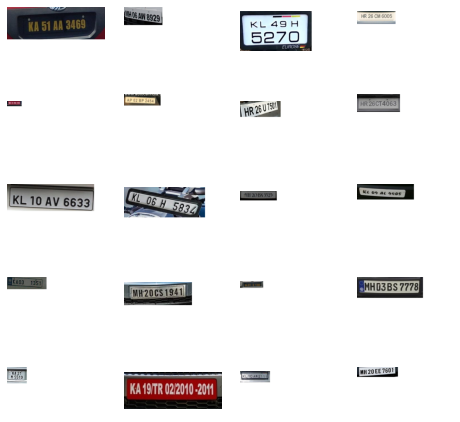

Character Accuracy: 0.00
Word Accuracy: nan


In [12]:
args['imgdir'] = 'test'
args['data'] = PlateDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')